In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datasets.skyline12 import Skyline12
from sklearn.model_selection import train_test_split

skyline12 = Skyline12('/storage/skyline12/data')
train_set, test_set = train_test_split(list(skyline12), train_size=100, random_state=0)
train_set, validation_set = train_test_split(train_set, train_size=0.8, random_state=42)
len(train_set), len(validation_set), len(test_set)

(80, 20, 20)

In [3]:
import tensorflow as tf
from datasets.skyline12 import create_augment_fn
from functools import partial
import numpy as np

NUM_CLASSES = 5
FOLDS = 10


def ds_gen(sample_set, folds):
    augment = create_augment_fn()

    def preprocess(x, y, z):
        x, y, z = augment(x, y, z)
        x = x.astype('float32')
        x /= 255.0
        y[y >= NUM_CLASSES - 1] = NUM_CLASSES - 1
        y = tf.keras.utils.to_categorical(y, num_classes=NUM_CLASSES)
        z = np.expand_dims(z, -1).astype('float32')
        z[z > 0] = 1.0
        return x, y, z

    for _ in range(folds):
        for x, y, z in sample_set:
            yield preprocess(x, y, z)


def split_outputs(x, y, z):
    return (x, (y, z))


train_ds = tf.data.Dataset.from_generator(
    partial(ds_gen, train_set, FOLDS),
    (
        tf.dtypes.float32,
        tf.dtypes.uint8,
        tf.dtypes.float32
    ),
    (
        tf.TensorShape([512, 512, 3]),
        tf.TensorShape([512, 512, NUM_CLASSES]),
        tf.TensorShape([512, 512, 1])
    )
).map(split_outputs)
validation_ds = tf.data.Dataset.from_generator(
    partial(ds_gen, validation_set, FOLDS // 2),
    (
        tf.dtypes.float32,
        tf.dtypes.uint8,
        tf.dtypes.float32
    ),
    (
        tf.TensorShape([512, 512, 3]),
        tf.TensorShape([512, 512, NUM_CLASSES]),
        tf.TensorShape([512, 512, 1])
    )
).map(split_outputs)

In [4]:
img, [annot, seed] = next(iter(train_ds))

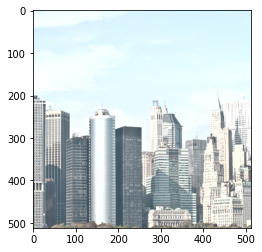

In [5]:
import matplotlib.pyplot as plt
plt.imshow(img)

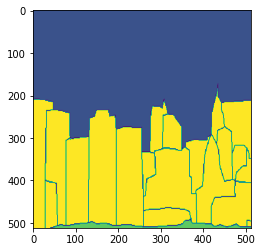

In [6]:
plt.imshow(annot.numpy().argmax(-1))

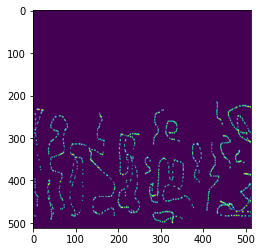

In [7]:
plt.imshow(seed)

In [8]:
from models.unet import create_unet
from tensorflow.keras.layers import Input, Conv2D

unet = create_unet()
unet.load_weights('checkpoints/baseline-weights.h5')

img = Input(shape=(512, 512, 3), name='X')
x = unet(img)
v = Conv2D(1, (1, 1), padding='same', activation='sigmoid', kernel_initializer='he_normal', name='Q')(x)
evid_model = tf.keras.Model(inputs=img, outputs=[x, v])
evid_model.compile(
    optimizer='adam',
    loss=['categorical_crossentropy', 'binary_crossentropy'],
    loss_weights=[1.0, 0.1],
    metrics=['accuracy'],
    run_eagerly=False
)

In [9]:
!rm -rf temp
!mkdir -p temp

In [10]:
import wandb
from wandb.keras import WandbCallback
from callbacks import WandbLogEvidencePredictions

early_stopper = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
class_labels = {
    0: 'Borders',
    1: 'Sky',
    2: 'Unknown',
    3: 'Unknown',
    4: 'Skyscrapers',
}
data_to_log = next(iter(validation_ds.batch(20)))
log_predictions = WandbLogEvidencePredictions(data_to_log, class_labels)

# wandb.init(project="skyline12-evidence", tags=[])
AUTOTUNE = tf.data.experimental.AUTOTUNE
evid_model.fit(
    train_ds.batch(3).cache('temp/').prefetch(AUTOTUNE),
    epochs=10,
    validation_data=validation_ds.batch(3).cache('temp/').prefetch(AUTOTUNE),
    callbacks=[
        early_stopper,
#         WandbCallback(),
#         log_predictions
    ]
)

Epoch 1/10
      2/Unknown - 0s 222ms/step - loss: 0.1878 - Unet_loss: 0.1418 - Q_loss: 0.4599 - Unet_accuracy: 0.9577 - Q_accuracy: 0.9314WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1475s vs `on_train_batch_end` time: 0.2957s). Check your callbacks.
267/267 [==============================] - 328s 1s/step - loss: 0.2007 - Unet_loss: 0.1630 - Q_loss: 0.3764 - Unet_accuracy: 0.9468 - Q_accuracy: 0.9493 - val_loss: 0.1741 - val_Unet_loss: 0.1415 - val_Q_loss: 0.3264 - val_Unet_accuracy: 0.9530 - val_Q_accuracy: 0.9493
Epoch 2/10
267/267 [==============================] - 161s 605ms/step - loss: 0.1907 - Unet_loss: 0.1614 - Q_loss: 0.2930 - Unet_accuracy: 0.9471 - Q_accuracy: 0.9493 - val_loss: 0.1667 - val_Unet_loss: 0.1402 - val_Q_loss: 0.2655 - val_Unet_accuracy: 0.9526 - val_Q_accuracy: 0.9493
Epoch 3/10
267/267 [==============================] - 162s 605ms/step - loss: 0.1862 - Unet_loss: 0.1614 - Q_loss: 0.2472 - Unet_acc

In [11]:
foo_x, [foo_y, foo_z] = next(iter(validation_ds.batch(1)))

In [12]:
y_pred, z_pred = evid_model(foo_x, training=False)

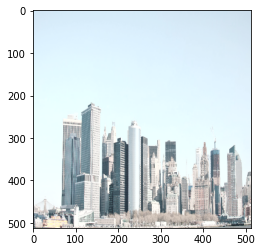

In [13]:
import matplotlib.pyplot as plt
plt.imshow(foo_x[0])

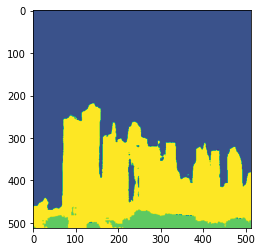

In [14]:
plt.imshow(y_pred[0].numpy().argmax(-1))

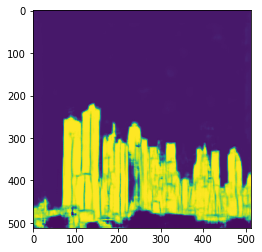

In [15]:
plt.imshow(z_pred[0])